In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CNCnoise_1.csv to CNCnoise_1.csv


In [ ]:
# === 데이터 로드 ===
data = pd.read_csv("CNCnoise_1.csv", header=None)
data.columns = ['noise']
raw_noise = data['noise'].values


In [ ]:
# 윈도우 시계열 구성
def create_dataset(data, look_back=10):
    X = []
    for i in range(len(data) - look_back):
        window = data[i:(i + look_back)].values.flatten()
        X.append(window)
    return np.array(X)

In [ ]:
# === 파라미터 설정 ===
look_back = 10
kmeans_n_clusters = 2
ma_window_size = 1000
ma_k = 2.5
iso_window_size = 1000
iso_step = 500
iso_contamination = 0.05
zscore_residual_threshold = 2.5  # residual 필터링 기준

In [ ]:
# === 전처리 및 특징 벡터 생성 ===
X = create_dataset(data['noise'], look_back)
noise_full = data['noise'].values[look_back:]

# === 정규화 (스케일링) ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 이동 평균 및 잔차 계산 ===
rolling_mean = pd.Series(noise_full).rolling(window=ma_window_size, center=True).mean()
rolling_std = pd.Series(noise_full).rolling(window=ma_window_size, center=True).std()
upper_bound = rolling_mean + ma_k * rolling_std
lower_bound = rolling_mean - ma_k * rolling_std
residual = noise_full - rolling_mean.fillna(method='bfill')
res_zscore = (residual - residual.mean()) / residual.std()

<ipython-input-6-4744e6789a9a>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  residual = noise_full - rolling_mean.fillna(method='bfill')


In [ ]:
# === 1. K-means 이상치 탐지 ===
kmeans = KMeans(n_clusters=kmeans_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)
is_outlier_kmeans = (noise_full > upper_bound.values) | (noise_full < lower_bound.values)

In [ ]:
# === 2. Isolation Forest 이상치 탐지 (슬라이딩 윈도우) + Moving Average 조건 ===
is_outlier_iso = np.zeros(len(noise_full), dtype=bool)

for start in range(0, len(X_scaled) - iso_window_size, iso_step):
    end = start + iso_window_size
    X_window = X_scaled[start:end]

    model = IsolationForest(contamination=iso_contamination, random_state=42)
    preds = model.fit_predict(X_window)

    for i, p in enumerate(preds):
        idx = start + i
        if p == -1 and idx < len(noise_full):
            if (
                (noise_full[idx] > upper_bound.values[idx]) or (noise_full[idx] < lower_bound.values[idx])
            ) and (np.abs(res_zscore[idx]) > zscore_residual_threshold):
                is_outlier_iso[idx] = True

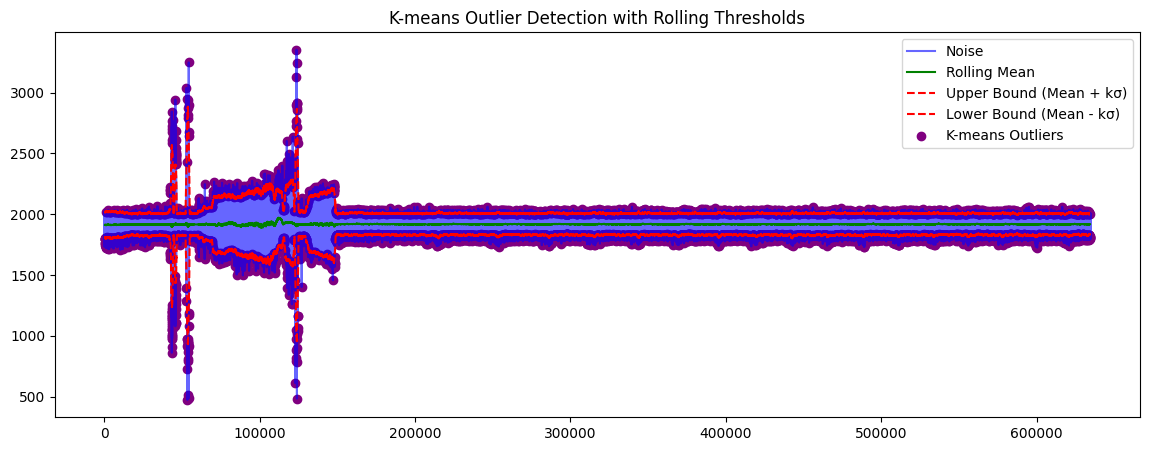

In [ ]:
# === 시각화: K-means ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (Mean + kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (Mean - kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_kmeans)[0], noise_full[is_outlier_kmeans], color='purple', label='K-means Outliers')
plt.title("K-means Outlier Detection with Rolling Thresholds")
plt.legend()
plt.show()

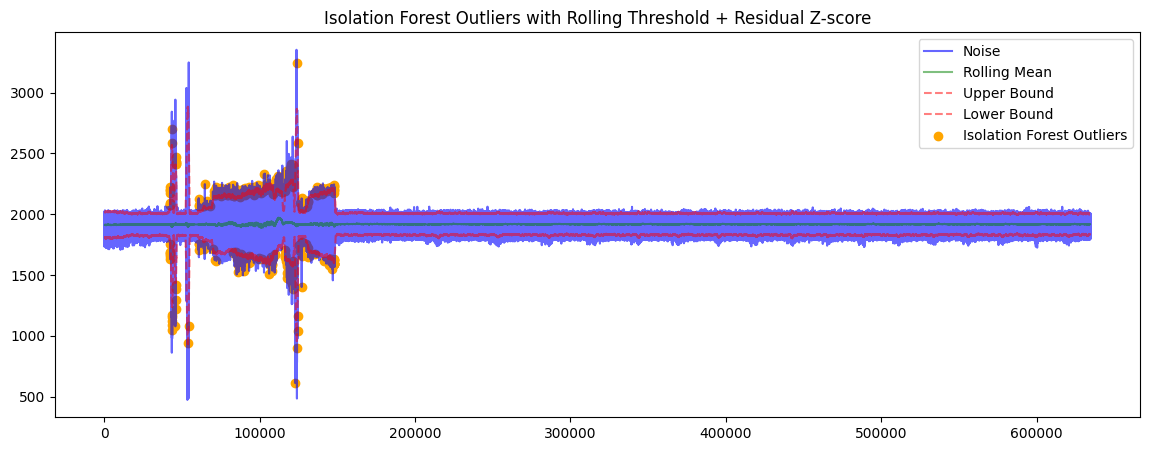

In [ ]:
# === 시각화: Isolation Forest ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green', alpha=0.5)
plt.plot(upper_bound, label='Upper Bound', color='red', linestyle='--', alpha=0.5)
plt.plot(lower_bound, label='Lower Bound', color='red', linestyle='--', alpha=0.5)
plt.scatter(np.where(is_outlier_iso)[0], noise_full[is_outlier_iso], color='orange', label='Isolation Forest Outliers')
plt.title("Isolation Forest Outliers with Rolling Threshold + Residual Z-score")
plt.legend()
plt.show()

In [ ]:
# === 파라미터 재설정 ===
ma_k = 3.0  # 주기적 변화 포함 방지 위해 완화
zscore_residual_threshold = 3.0
iso_contamination = 0.01  # 이상치 비율을 낮춰 민감도 감소

In [ ]:
# === 이동 평균 및 잔차 재계산 ===
rolling_mean = pd.Series(noise_full).rolling(window=ma_window_size, center=True).mean()
rolling_std = pd.Series(noise_full).rolling(window=ma_window_size, center=True).std()
upper_bound = rolling_mean + ma_k * rolling_std
lower_bound = rolling_mean - ma_k * rolling_std
residual = noise_full - rolling_mean.bfill()
res_zscore = (residual - residual.mean()) / residual.std()

In [ ]:
# === K-means 이상치 재탐지 ===
kmeans = KMeans(n_clusters=kmeans_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)
# 주기성 제거 위해 threshold 조건 추가
is_outlier_kmeans = ((noise_full > upper_bound.values) | (noise_full < lower_bound.values)) & (np.abs(res_zscore) > zscore_residual_threshold)

# === Isolation Forest 이상치 재탐지 ===
is_outlier_iso = np.zeros(len(noise_full), dtype=bool)

for start in range(0, len(X_scaled) - iso_window_size, iso_step):
    end = start + iso_window_size
    X_window = X_scaled[start:end]

    model = IsolationForest(contamination=iso_contamination, random_state=42)
    preds = model.fit_predict(X_window)

    for i, p in enumerate(preds):
        idx = start + i
        if p == -1 and idx < len(noise_full):
            if (
                (noise_full[idx] > upper_bound.values[idx]) or (noise_full[idx] < lower_bound.values[idx])
            ) and (np.abs(res_zscore[idx]) > zscore_residual_threshold):
                is_outlier_iso[idx] = True

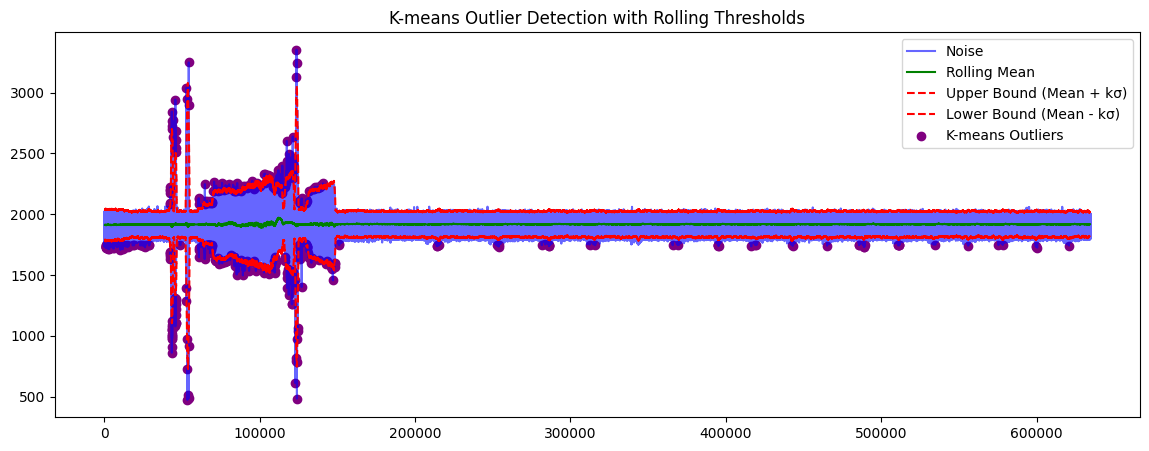

In [ ]:
# === 재시각화: K-means ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (Mean + kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (Mean - kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_kmeans)[0], noise_full[is_outlier_kmeans], color='purple', label='K-means Outliers')
plt.title("K-means Outlier Detection with Rolling Thresholds")
plt.legend()
plt.show()

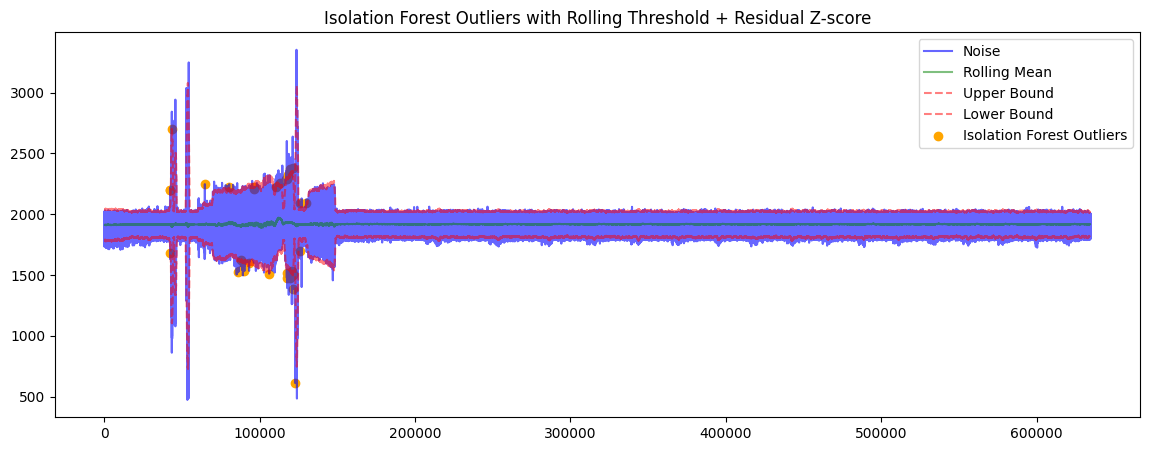

In [ ]:
# === 재시각화: Isolation Forest ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green', alpha=0.5)
plt.plot(upper_bound, label='Upper Bound', color='red', linestyle='--', alpha=0.5)
plt.plot(lower_bound, label='Lower Bound', color='red', linestyle='--', alpha=0.5)
plt.scatter(np.where(is_outlier_iso)[0], noise_full[is_outlier_iso], color='orange', label='Isolation Forest Outliers')
plt.title("Isolation Forest Outliers with Rolling Threshold + Residual Z-score")
plt.legend()
plt.show()

In [ ]:
# 파라미터 재조정
ma_k = 3.5
zscore_residual_threshold = 3.5
iso_contamination = 0.005

In [ ]:
# === 이동 평균 및 잔차 재계산 ===
rolling_mean = pd.Series(noise_full).rolling(window=ma_window_size, center=True).mean()
rolling_std = pd.Series(noise_full).rolling(window=ma_window_size, center=True).std()
upper_bound = rolling_mean + ma_k * rolling_std
lower_bound = rolling_mean - ma_k * rolling_std
residual = noise_full - rolling_mean.bfill()
res_zscore = (residual - residual.mean()) / residual.std()

In [ ]:
# K-means 재탐지
kmeans = KMeans(n_clusters=kmeans_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)
is_outlier_kmeans = ((noise_full > upper_bound.values) | (noise_full < lower_bound.values)) & (np.abs(res_zscore) > zscore_residual_threshold)

# Isolation Forest 재탐지
is_outlier_iso = np.zeros(len(noise_full), dtype=bool)

for start in range(0, len(X_scaled) - iso_window_size, iso_step):
    end = start + iso_window_size
    X_window = X_scaled[start:end]

    model = IsolationForest(contamination=iso_contamination, random_state=42)
    preds = model.fit_predict(X_window)

    for i, p in enumerate(preds):
        idx = start + i
        if p == -1 and idx < len(noise_full):
            if (
                (noise_full[idx] > upper_bound.values[idx]) or (noise_full[idx] < lower_bound.values[idx])
            ) and (np.abs(res_zscore[idx]) > zscore_residual_threshold):
                is_outlier_iso[idx] = True

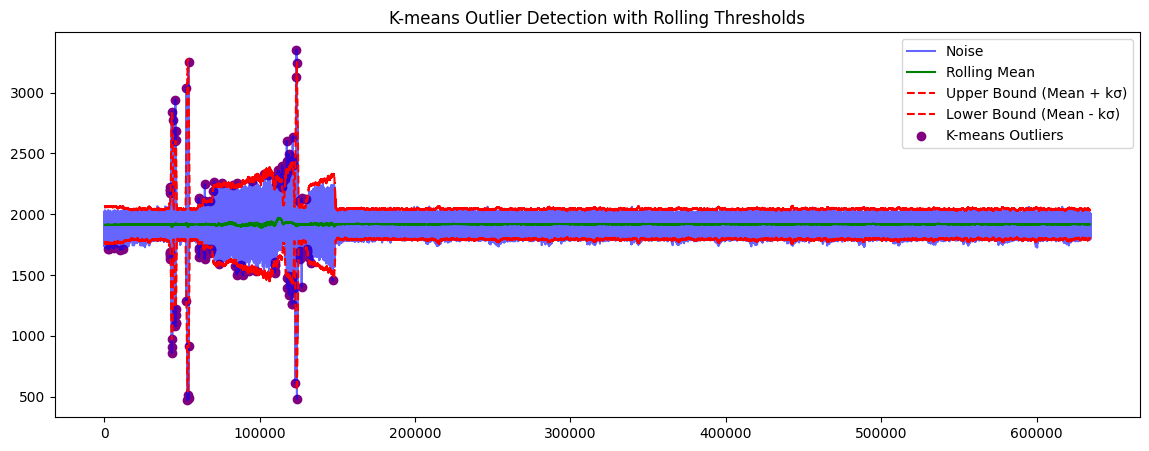

In [ ]:
# === 재시각화: K-means ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (Mean + kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (Mean - kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_kmeans)[0], noise_full[is_outlier_kmeans], color='purple', label='K-means Outliers')
plt.title("K-means Outlier Detection with Rolling Thresholds")
plt.legend()
plt.show()

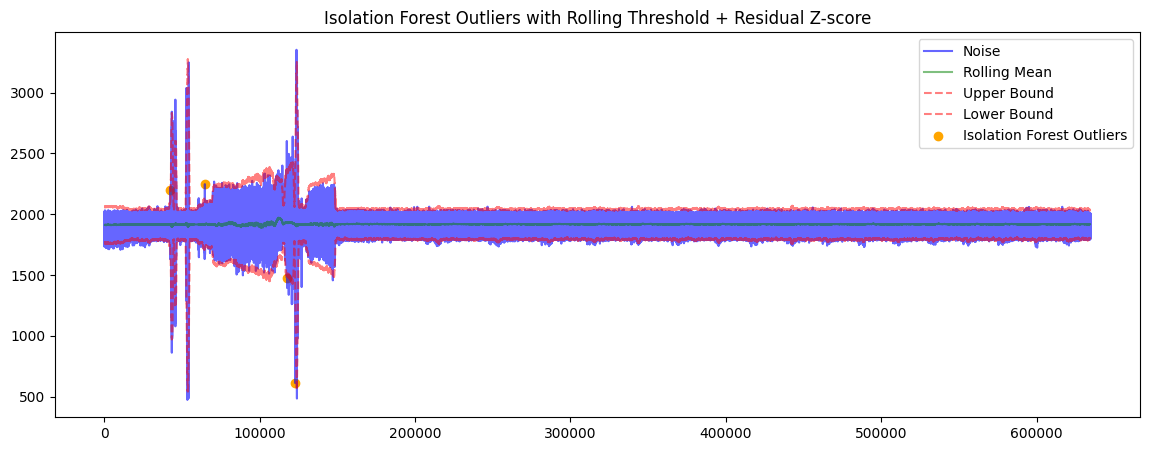

In [ ]:
# === 재시각화: Isolation Forest ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green', alpha=0.5)
plt.plot(upper_bound, label='Upper Bound', color='red', linestyle='--', alpha=0.5)
plt.plot(lower_bound, label='Lower Bound', color='red', linestyle='--', alpha=0.5)
plt.scatter(np.where(is_outlier_iso)[0], noise_full[is_outlier_iso], color='orange', label='Isolation Forest Outliers')
plt.title("Isolation Forest Outliers with Rolling Threshold + Residual Z-score")
plt.legend()
plt.show()

In [ ]:
# 파라미터 미세 조정
ma_k = 4.0
zscore_residual_threshold = 4.0
iso_contamination = 0.002

In [ ]:
# === 이동 평균 및 잔차 재계산 ===
rolling_mean = pd.Series(noise_full).rolling(window=ma_window_size, center=True).mean()
rolling_std = pd.Series(noise_full).rolling(window=ma_window_size, center=True).std()
upper_bound = rolling_mean + ma_k * rolling_std
lower_bound = rolling_mean - ma_k * rolling_std
residual = noise_full - rolling_mean.bfill()
res_zscore = (residual - residual.mean()) / residual.std()

In [ ]:
# K-means 재탐지
kmeans = KMeans(n_clusters=kmeans_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)
is_outlier_kmeans = ((noise_full > upper_bound.values) | (noise_full < lower_bound.values)) & (np.abs(res_zscore) > zscore_residual_threshold)

# Isolation Forest 재탐지
is_outlier_iso = np.zeros(len(noise_full), dtype=bool)

for start in range(0, len(X_scaled) - iso_window_size, iso_step):
    end = start + iso_window_size
    X_window = X_scaled[start:end]

    model = IsolationForest(contamination=iso_contamination, random_state=42)
    preds = model.fit_predict(X_window)

    for i, p in enumerate(preds):
        idx = start + i
        if p == -1 and idx < len(noise_full):
            if (
                (noise_full[idx] > upper_bound.values[idx]) or (noise_full[idx] < lower_bound.values[idx])
            ) and (np.abs(res_zscore[idx]) > zscore_residual_threshold):
                is_outlier_iso[idx] = True

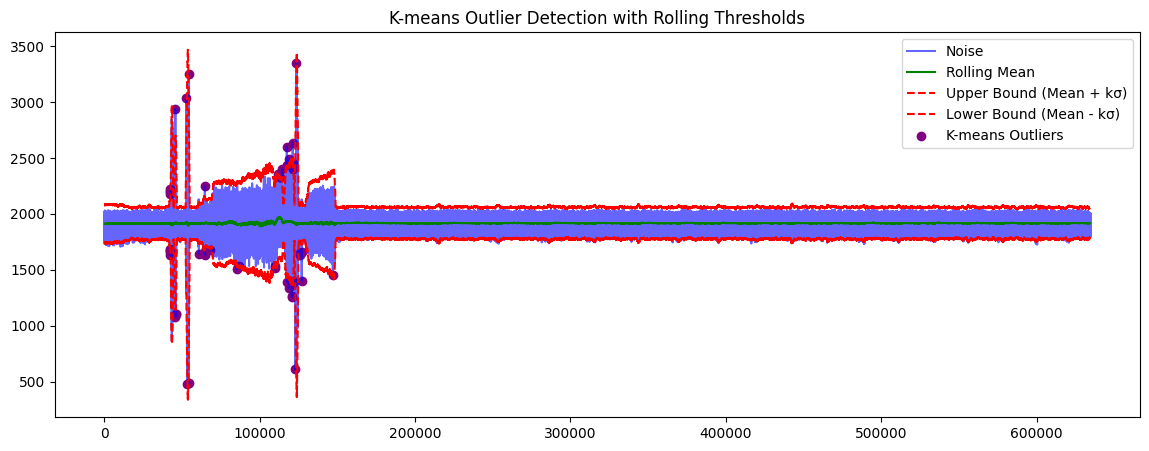

In [ ]:
# === 재시각화: K-means ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (Mean + kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (Mean - kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_kmeans)[0], noise_full[is_outlier_kmeans], color='purple', label='K-means Outliers')
plt.title("K-means Outlier Detection with Rolling Thresholds")
plt.legend()
plt.show()

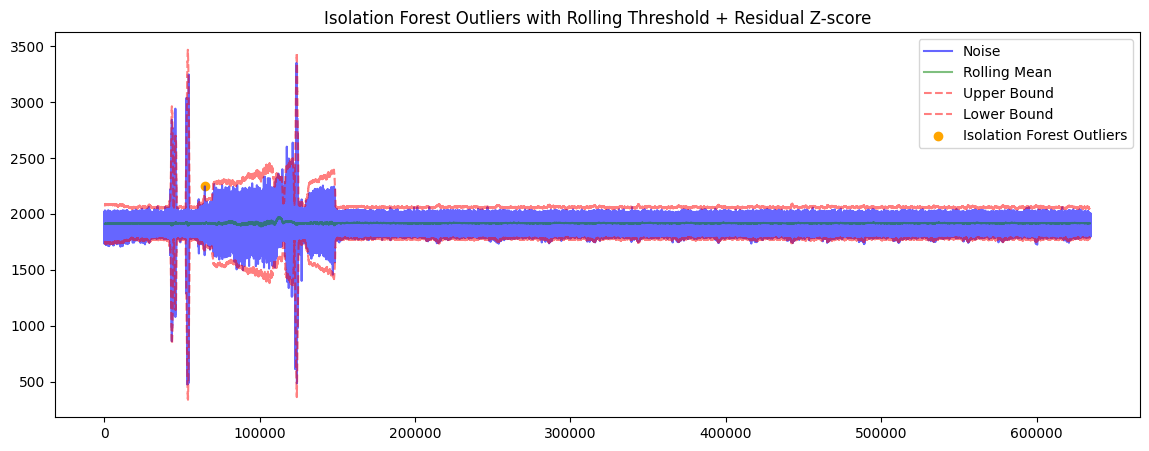

In [ ]:
# === 재시각화: Isolation Forest ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green', alpha=0.5)
plt.plot(upper_bound, label='Upper Bound', color='red', linestyle='--', alpha=0.5)
plt.plot(lower_bound, label='Lower Bound', color='red', linestyle='--', alpha=0.5)
plt.scatter(np.where(is_outlier_iso)[0], noise_full[is_outlier_iso], color='orange', label='Isolation Forest Outliers')
plt.title("Isolation Forest Outliers with Rolling Threshold + Residual Z-score")
plt.legend()
plt.show()

In [ ]:
# === 파라미터 재설정 ===
ma_k = 4.0
zscore_residual_threshold = 4.0
iso_contamination = 0.5  # 이전보다 완화해서 극단적 이상치 탐지

# === 이동 평균 및 잔차 재계산 ===
rolling_mean = pd.Series(noise_full).rolling(window=ma_window_size, center=True).mean()
rolling_std = pd.Series(noise_full).rolling(window=ma_window_size, center=True).std()
upper_bound = rolling_mean + ma_k * rolling_std
lower_bound = rolling_mean - ma_k * rolling_std
residual = noise_full - rolling_mean.fillna(method='bfill')
res_zscore = (residual - residual.mean()) / residual.std()

# === K-means 재탐지 (거리 기반 filtering 추가) ===
kmeans = KMeans(n_clusters=kmeans_n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)

# 거리 기반 filtering을 위한 z-score 계산
distance_z = (distances - distances.mean()) / distances.std()

# 3조건: distance_z + rolling bound + residual z-score
is_outlier_kmeans = (
    ((noise_full > upper_bound.values) | (noise_full < lower_bound.values)) &
    (np.abs(res_zscore) > zscore_residual_threshold) &
    (distance_z > 2.0)
)

# === Isolation Forest 재탐지 (contamination 완화) ===
is_outlier_iso = np.zeros(len(noise_full), dtype=bool)

for start in range(0, len(X_scaled) - iso_window_size, iso_step):
    end = start + iso_window_size
    X_window = X_scaled[start:end]

    model = IsolationForest(contamination=iso_contamination, random_state=42)
    preds = model.fit_predict(X_window)

    for i, p in enumerate(preds):
        idx = start + i
        if p == -1 and idx < len(noise_full):
            if (
                (noise_full[idx] > upper_bound.values[idx]) or (noise_full[idx] < lower_bound.values[idx])
            ) and (np.abs(res_zscore[idx]) > zscore_residual_threshold):
                is_outlier_iso[idx] = True


<ipython-input-44-ce7452076c52>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  residual = noise_full - rolling_mean.fillna(method='bfill')


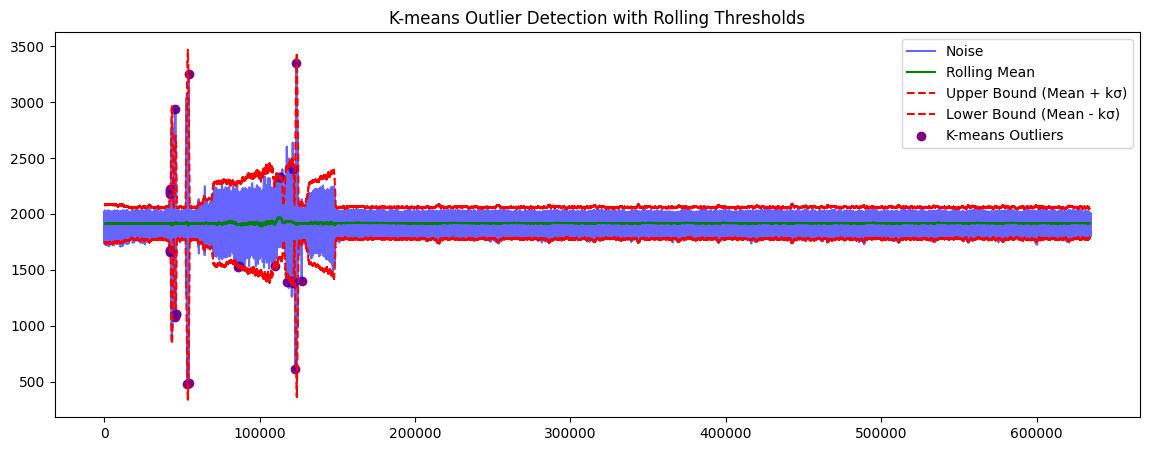

In [ ]:
# === 재시각화: K-means ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(upper_bound, label='Upper Bound (Mean + kσ)', color='red', linestyle='--')
plt.plot(lower_bound, label='Lower Bound (Mean - kσ)', color='red', linestyle='--')
plt.scatter(np.where(is_outlier_kmeans)[0], noise_full[is_outlier_kmeans], color='purple', label='K-means Outliers')
plt.title("K-means Outlier Detection with Rolling Thresholds")
plt.legend()
plt.show()

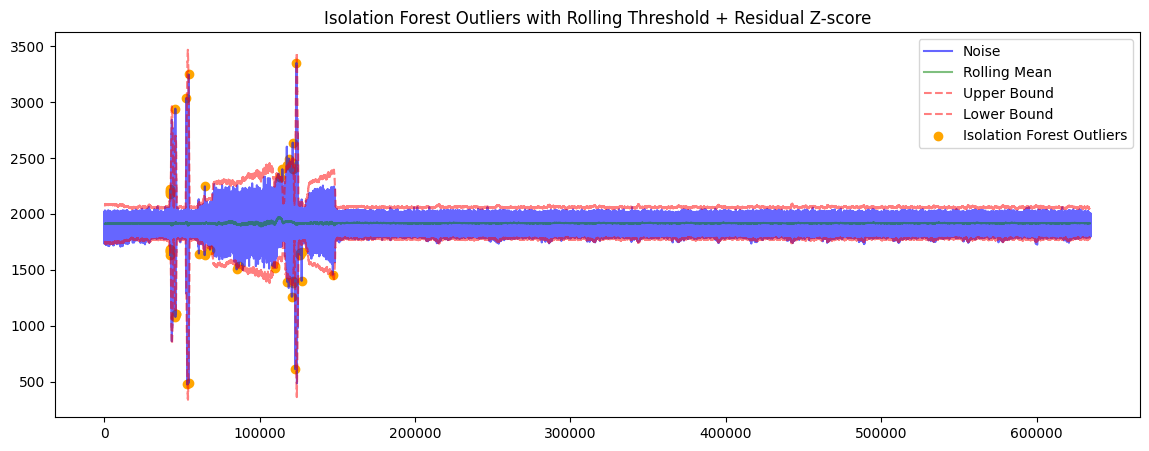

In [ ]:
# === 재시각화: Isolation Forest ===
plt.figure(figsize=(14, 5))
plt.plot(noise_full, label='Noise', color='blue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean', color='green', alpha=0.5)
plt.plot(upper_bound, label='Upper Bound', color='red', linestyle='--', alpha=0.5)
plt.plot(lower_bound, label='Lower Bound', color='red', linestyle='--', alpha=0.5)
plt.scatter(np.where(is_outlier_iso)[0], noise_full[is_outlier_iso], color='orange', label='Isolation Forest Outliers')
plt.title("Isolation Forest Outliers with Rolling Threshold + Residual Z-score")
plt.legend()
plt.show()